## Notebook for Solar Wind Exploration

In the initial phase, we want to see if we can detect FTEs using unsupervised learning, by finding a manifold for the solar wind data.

The initial hypothesis is the transition matrices (Markov Matrices $M$) that can be derived from Manifolder + clustering will show distinctive clusters and transitions.  We can check accuracy by looking at the label (FTE or not?), and see if this label could have been deduced from the data itself.



In [1]:
# useful set of python includes

%load_ext autoreload
%autoreload 2

import numpy as np

np.set_printoptions(suppress=True, precision=4)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

# import seaborn as sns
# sns.set()

import pandas as pd

import time

import random

import os

### Load Solar Wind Data, and Run Manifolder

The `dataset_2` file contains 

Dataset-2 (THEMIS):   a list with FTEs periods and non-FTEs periods observed by THEMIS in 2007.  These are combined into one file, randomly FTE - NonFTE - FTE - FTE, NonFTE, etc…

In total there are 63 FTEs and 47 non-FTEs.

The time series are separated by one blank line, and each one has 1440 points in a period of 6 minutes.


In [2]:
os.getcwd()

'C:\\Users\\Trey\\Documents\\GitHub\\manifolder\\code\\astro\\final_notebooks'

In [3]:
import sys
sys.path.append(r"..")
sys.path.append(r"../..")

#sys.path.append("/home/jovyan/gen-mod-vol/avlab/manifolder/code")

import manifolder as mr
from manifolder import helper as mh


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [4]:
# load the data
# note, you must have started the notebook in the 
print('loading data ...')
df = pd.read_excel('astro_data/dataset_2.xlsx', index_col=0)
df.head()

loading data ...


,sc\ttime\t\t,bx\t,by\t,bz\t,bl\t,bm\t,bn\t,bmag\t,vx\t,vy\t,vz\t,vmag\t,np,tpar,tper,tp,goal
thd,1.177999e+09,2.06,-4.87,17.77,17.80,4.55,-2.48,18.54,-5.96,2.42,6.94,9.46,0.11,3938.25,3565.04,3689.44,1.0
thd,1.177999e+09,2.01,-4.89,17.69,17.72,4.53,-2.53,18.47,-7.04,1.11,6.79,9.85,0.11,3924.28,3610.40,3715.03,1.0
thd,1.177999e+09,2.01,-4.87,17.71,17.74,4.51,-2.52,18.48,-8.14,-0.21,6.66,10.52,0.11,3910.35,3656.06,3740.82,1.0
thd,1.177999e+09,2.02,-4.80,17.74,17.77,4.47,-2.45,18.48,-9.23,-1.53,6.52,11.40,0.11,3896.40,3701.56,3766.51,1.0
thd,1.177999e+09,1.99,-4.83,17.70,17.73,4.47,-2.50,18.45,-10.26,-2.82,6.37,12.40,0.11,3882.37,3746.46,3791.77,1.0


In [5]:
# convert values from loaded spreadsheet, into a numpy matrices
# note that there is no need for the first value, which is time,
# as it is not part of the manifold
#
# also, note the spreadsheet is missing a column name for `Unnamed: 13`, and the values above
# this have the incorrect column labels; the first relevant vale is bx, which as a magnitude around 2
#
# note the final value of each row is the goal (0 or 1), and not part of z

data_raw = df.values[:, 1:]
print('first line of raw_data:\n', data_raw[0, :])
print(data_raw.shape)


first line of raw_data:
 [   2.06   -4.87   17.77   17.8     4.55   -2.48   18.54   -5.96    2.42
    6.94    9.46    0.11 3938.25 3565.04 3689.44    1.  ]
(149863, 16)


In [6]:
import pickle
#Load Data
segments = np.load('themis/segments-newdata-all.npy')

# Load Labels
labels = np.load('themis/labels-newdata-all.npy')
labels = np.asarray(pd.get_dummies(labels))

#Load Bounding Boxes/ Event Locations
with open('themis/bbox.pickle','rb') as f:
    bboxes = pickle.load(f)

In [7]:
# loop through the data, breaking out the clusters
# i will always point to the NaN (blank line) in the dataframe,
# and values [i-1440:i] is the snipped

snippet_len = 1440

# collect all line breaks (blank lines) in csv file
#lineBreaks = [0]
#for i in range(data_raw.shape[0]):
#    if data_raw[i,0] != data_raw[i,0]:  # replacement of isnan, since nan != nan
#        lineBreaks.append(i)    
#lineBreaks.append(data_raw.shape[0])
#
#num_snippet = len(lineBreaks)-1


# callect the snippets into two groups, one for each goal (target) value, 0 or 1
# these can be easily merged
zs_0 = []
zs_1 = []

locallabel_0 = []
locallabel_1 = []
snippet_index = 0

df.values[0,:]

reduce_dimension = True

for i in range(snippet_len,data_raw.shape[0]+1,snippet_len+1):
    # copy the snipped, excluding the last value, which is the goal
    snippet = data_raw[i-snippet_len:i,:-1]
    
    if reduce_dimension:
        snippet = snippet[:,0]
        snippet = snippet.reshape(snippet_len,1)

    # grab the goal value from the first row of each snippet
    goal = data_raw[i-snippet_len,-1]
    
    # check to make sure each snippet does not contain NaN
    # (should not, if parsing is correct)
    assert ~np.isnan(snippet).any(), 'oops, snippet contains a Nan!'
    
    print('snippet size',snippet.shape,'with goal',goal)
    
    snippetlabel = np.zeros(snippet_len)
    if goal == 1:
        bmin = int(bboxes[snippet_index][0][0])
        bmax = int(bboxes[snippet_index][0][2])
        snippetlabel[bmin:bmax] = 1
    
    if goal == 0:
        zs_0.append( snippet )
        locallabel_0.append( snippetlabel )
    elif goal == 1:
        zs_1.append( snippet )
        locallabel_1.append( snippetlabel )
    else:
        assert False, 'value of goal not understood'
        
    snippet_index = snippet_index + 1
        

# shuffle this lists; this should not strictly be necessary, if all the data is being used,
# but prevents biases when shortening the list

c0 = list(zip(zs_0, locallabel_0))
random.shuffle(c0)
zs_0, locallabel_0 = zip(*c0)
zs_0 = list(zs_0)
locallabel_0 = list(locallabel_0)

c1 = list(zip(zs_1, locallabel_1))
random.shuffle(c1)
zs_1, locallabel_1 = zip(*c1)
zs_1 = list(zs_1)
locallabel_1 = list(locallabel_1)

shorten_data = False

if shorten_data:
    zs_0 = zs_0[:20]
    zs_1 = zs_1[:20]
    locallabel_0 = locallabel_0[:20]
    locallabel_1 = locallabel_1[:20]
        
zs = zs_0 + zs_1
locallabel = locallabel_0 + locallabel_1
z_breakpoint = len(zs_0)

print( '\done!')
print( '\t len(zs_0):',len(zs_0))
print( '\t len(zs_1):',len(zs_1))
print( '\t len(zs):',len(zs))




dim=6
H = 160
step_size = 20
nbins = 10
ncov = 10
num_rdims = 10

snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
s

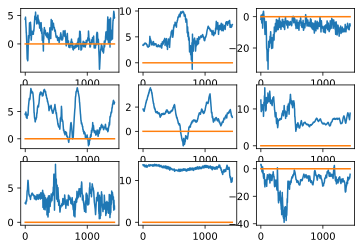

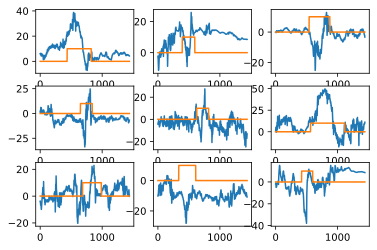

In [8]:
# import matplotlib.pyplot as plt

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(zs_0[i][:,5])
    else:
        plt.plot(zs_0[i][:,0])
        
    plt.plot(10*locallabel_0[i])
    
plt.show()

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(zs_1[i][:,5])
    else:
        plt.plot(zs_1[i][:,0])
    plt.plot(10*locallabel_1[i])

    
plt.show()

In [9]:
# data has been parsed, now run Manifolder


start_time = time.time()

# create manifolder object
manifolder = mr.Manifolder(dim=dim,H=H,step_size=step_size,nbins=nbins, ncov=ncov, num_rdims=num_rdims)

# add the data, and fit (this runs all the functions)
# manifolder.fit_transform(zs, parallel=False, dtw="raw")
# manifolder.fit_transform(zs, parallel=False, dtw="zscore", dtw_dims=(0,))
# manifolder.fit_transform(zs, parallel=True)
manifolder.fit_transform(zs)

elapsed_time = time.time() - start_time
print('\n\t Program Executed in', str(np.round(elapsed_time, 2)), 'seconds')


calculating histograms for snip  0  of  104  (dim  1  timeseries) . done
calculating histograms for snip  1  of  104  (dim  1  timeseries) . done
calculating histograms for snip  2  of  104  (dim  1  timeseries) . done
calculating histograms for snip  3  of  104  (dim  1  timeseries) . done
calculating histograms for snip  4  of  104  (dim  1  timeseries) . done
calculating histograms for snip  5  of  104  (dim  1  timeseries) . done
calculating histograms for snip  6  of  104  (dim  1  timeseries) . done
calculating histograms for snip  7  of  104  (dim  1  timeseries) . done
calculating histograms for snip  8  of  104  (dim  1  timeseries) . done
calculating histograms for snip  9  of  104  (dim  1  timeseries) . done
calculating histograms for snip  10  of  104  (dim  1  timeseries) . done
calculating histograms for snip  11  of  104  (dim  1  timeseries) . done
calculating histograms for snip  12  of  104  (dim  1  timeseries) . done
calculating histograms for snip  13  of  104  (d

computing local covariances for snip  8  of  104......... done
computing local covariances for snip  9  of  104......... done
computing local covariances for snip  10  of  104......... done
computing local covariances for snip  11  of  104......... done
computing local covariances for snip  12  of  104......... done
computing local covariances for snip  13  of  104......... done
computing local covariances for snip  14  of  104......... done
computing local covariances for snip  15  of  104......... done
computing local covariances for snip  16  of  104......... done
computing local covariances for snip  17  of  104......... done
computing local covariances for snip  18  of  104......... done
computing local covariances for snip  19  of  104......... done
computing local covariances for snip  20  of  104......... done
computing local covariances for snip  21  of  104......... done
computing local covariances for snip  22  of  104......... done
computing local covariances for snip  23  

In [10]:
locallabel_downsample = np.empty(0, float)
for i in range(len(locallabel)):
    x = locallabel[i]
    x = x[0:x.shape[0]-H]
    x = x[::step_size]

    locallabel_downsample = np.append(locallabel_downsample,x,0)
    
Psi = manifolder.Psi[:,0:manifolder.Dim]
    
print(locallabel_downsample.shape)
print(Psi.shape)

(6656,)
(6656, 6)


In [11]:
x = locallabel[0]
x = x[0:x.shape[0]-H]
x = x[::step_size]
print(x.shape)
print(1440*104)
print(manifolder.Psi.shape[0])

(64,)
149760
6656


In [12]:
snippet_psi = []
size = manifolder.Psi.shape[0] // len(zs)
for i in range(0, manifolder.Psi.shape[0], size):
    snippet_psi.append(manifolder.Psi[i:i+size, :])

print(size)
print(manifolder.Psi.shape[0])

64
6656


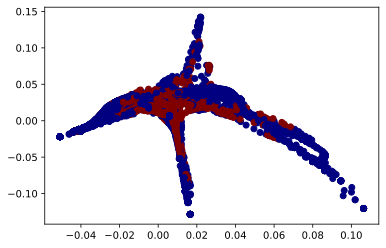

In [13]:
plt.scatter(manifolder.Psi[:,0],manifolder.Psi[:,2],c=locallabel_downsample,cmap='jet')

# perform kmeans clustering on data

from sklearn.cluster import KMeans
singledim = []
for snippet in zs:
    singledim.append(snippet[:,0])

results = []
for i in range(10000):
    kmeans_orig = KMeans(n_clusters=2).fit(singledim)
    found = False
    for temp in results:
        if (kmeans_orig.labels_ == temp[0]).all() or (kmeans_orig.labels_ != temp[0]).all():
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeans_orig.labels_, 1])
results = sorted(results, key=lambda array: array[1])
print(results)
cluster_out = results[-1][0]
print(cluster_out)
truePositive = 0
falsePositive = 0
trueNegative = 0
falseNegative=0
for i in range(len(zs_0)):
    if cluster_out[i] == 0:
        trueNegative += 1
    else:
        falsePositive += 1
for i in range(len(zs_0), len(zs)):
    if cluster_out[i] == 1:
        truePositive += 1
    else:
        falseNegative += 1
print("TN:", trueNegative)
print("FP:", falsePositive)
print("TP:", truePositive)
print("FN:", falseNegative)

In [14]:
# intermediate data structures

snippet_windows = []
for snip in range(len(zs)):
    z = zs[snip]
    i_range = int(np.floor(z.shape[0] - H) / step_size)
    window = np.zeros((H, i_range))
    #print(window.shape)
    for i in range(i_range):
        # interval = z(dim, 1 + (i - 1) * stepSize: (i - 1) * stepSize + H);
        interval = z[i * step_size:i * step_size + H, 0]
        #print(interval.shape)
        window[:, i] = interval
    snippet_windows.append(window)
print(snippet_windows)

wps = snippet_windows[0].shape[1]
window_array = np.zeros((len(snippet_windows)*wps, H))
print(window_array.shape)
for i in range(len(zs)):
    start = wps * i
    end = wps * (i+1)
    window_array[start:end,:] = snippet_windows[i].T

# build list of index pairs for the initial medoids
tot = len(zs)
idx = []
for i1 in range(tot):
    for j1 in range((tot-1)):
        temp = [i1,j1]
        idx.append(temp)

[array([[ 4.33,  1.71, -2.96, ..., -0.88, -0.52, -1.32],
       [ 4.49,  1.43, -2.86, ..., -0.78, -0.71, -1.6 ],
       [ 4.48,  1.1 , -2.88, ..., -0.75, -0.88, -1.55],
       ...,
       [ 4.7 ,  4.46,  4.35, ...,  3.67,  1.36,  4.14],
       [ 4.6 ,  4.62,  4.52, ...,  2.84,  1.49,  4.12],
       [ 4.72,  4.7 ,  4.81, ...,  2.37,  1.74,  4.14]]), array([[3.37, 3.57, 3.77, ..., 6.01, 6.64, 7.58],
       [3.44, 3.64, 3.78, ..., 6.32, 6.57, 7.62],
       [3.5 , 3.67, 3.77, ..., 6.31, 6.51, 7.57],
       ...,
       [3.72, 3.42, 3.62, ..., 8.  , 7.97, 6.97],
       [3.71, 3.52, 3.64, ..., 7.9 , 7.68, 7.  ],
       [3.8 , 3.58, 3.65, ..., 7.65, 7.39, 6.95]]), array([[ -1.71,  -0.7 ,   2.45, ...,  -4.74,  -6.81, -10.69],
       [ -1.15,  -0.29,   3.39, ...,  -5.34,  -6.09, -12.04],
       [ -1.54,   0.31,   3.17, ...,  -6.29,  -5.71, -12.44],
       ...,
       [-10.25, -15.56, -14.85, ...,  -6.99,  -4.22,  -7.06],
       [ -9.6 , -14.03, -14.54, ...,  -6.73,  -4.21,  -6.64],
       [ -9.9

In [15]:
# clustering functions

from pyclustering.cluster.kmedoids import kmedoids

def try_medoids(nclust, dm, initial_medoids=None):
    len_data = dm.shape[0]
    if initial_medoids == None:
        initial_medoids = random.sample(range(len_data), nclust)
    kmedoids_instance = kmedoids(dm, initial_medoids, data_type = 'distance_matrix')
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    #print(clusters)
    clusters[0].sort()
    clusters[1].sort()
    return clusters

def run_clustering(dm, print_results=False):
    results = []
    for i in range(len(idx)):
        kmeds = try_medoids(2, dm, initial_medoids=idx[i])
        found = False
        for temp in results:
            if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1])) or \
            (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
                temp[1] += 1
                found = True
                break
        if not found:
            results.append([kmeds, 1])
    if print_results:
        print("########################################################################")
        print("before sorting")
        print(results)
        print("after sorting")
    results = sorted(results, key=lambda array: array[1])
    if print_results:
        print(results)
        print("########################################################################")
    return results

def print_clustering_stats(results, level=2):
    for i in range(len(results)):
        cluster_out = results[len(results)-1-i][0]
        print(cluster_out)
        res_temp = results[len(results)-1-i][1]
        print(res_temp)
        trueNegative = 0
        falseNegative = 0
        truePositive = 0
        falsePositive = 0
        for i in range(len(cluster_out[0])):
            if cluster_out[0][i] < len(zs_0):
                trueNegative += 1
            else:
                falseNegative += 1
        for i in range(len(cluster_out[1])):
            if cluster_out[1][i] >= len(zs_0):
                truePositive += 1
            else:
                falsePositive += 1
        if level <= 2:
            print("TN: ", trueNegative)
            print("FP: ", falsePositive)
            print("TP: ", truePositive)
            print("FN: ", falseNegative)
        if level >= 2:
            numCorrect = max(truePositive+trueNegative,falsePositive+falseNegative)
            print("Total: ", numCorrect, "/", len(zs))
            accuracy = ((numCorrect/len(zs))-0.5) * 200
            print("Accuracy: ", accuracy, "%")

In [16]:
# Manifolder with Energy Distance

# calculate energy distance matrix for dimension reduced data from manifolder
snippet_psi = []
size = manifolder.Psi.shape[0] // len(zs)
for i in range(0, manifolder.Psi.shape[0], size):
    snippet_psi.append(manifolder.Psi[i:i+size, :])

import dcor
dcor_dm = np.zeros((len(zs), len(zs)))
start_time = time.time()
for i in range(len(snippet_psi)):
    for j in range(i):
        distance = dcor.homogeneity.energy_test_statistic(snippet_psi[i], snippet_psi[j])
        dcor_dm[i,j] = distance
        dcor_dm[j,i] = distance
print('\n\t Dcor Executed in', str(np.round(time.time() - start_time, 2)), 'seconds')
print(dcor_dm)

manifolder_results = run_clustering(dcor_dm)
print_clustering_stats(manifolder_results)



	 Dcor Executed in 1.21 seconds
[[0.     0.1253 2.5351 ... 0.8037 0.5193 1.3153]
 [0.1253 0.     2.8528 ... 1.2701 0.9881 1.826 ]
 [2.5351 2.8528 0.     ... 1.9539 2.3261 2.046 ]
 ...
 [0.8037 1.2701 1.9539 ... 0.     0.3624 0.4585]
 [0.5193 0.9881 2.3261 ... 0.3624 0.     0.6853]
 [1.3153 1.826  2.046  ... 0.4585 0.6853 0.    ]]
[[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103], [7, 11, 13, 22, 28, 40, 41, 43, 48, 57, 89]]
6705
TN:  39
FP:  8
TP:  3
FN:  54
Total:  62 / 104
Accuracy:  19.23076923076923 %
[[2, 7, 8, 10, 11, 12, 13, 16, 20, 21, 22, 23, 25, 27, 28, 32, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 61, 62, 65, 66, 68, 69

# Accuracy for num_rdims = 10, manifolder dim =5
TN: 15
FP: 0
TP: 57
FN: 32

TN: 39
FP: 54
TP: 3
FN: 8

TN: 13
FP: 44
TP: 13
FN: 34


# Accuracy for num_rdims = 10, manifolder dim = 0
TN: 39
FP: 54
TP: 3
FN: 8

# Accuracy for num_rdims = 50, manifolder dim = 0
TN: 19
FP: 45
TP: 12
FN: 28

TN: 39
FP: 55
TP: 2
FN: 8

In [17]:
######################################################
#Cross-check of DTW versus Matlab
# This code is for verification only
######################################################

import math
x = []
for i in range(1000):
    x.append(math.cos(2*math.pi*((3*i/1000)**2)))
y = []
for i in range(400):
    y.append(math.cos(2*math.pi*18*i/400))

import dtw
temp = dtw.dtw(x,y)
print(temp.distance)

179.3527858690105


In [18]:
# DTW
import pickle
try:
    f = open("../dtw_distmat_zscore_dim_0.pickle", 'rb')
    dtw_distmat_dim_0 = pickle.load(f)
finally:
    f.close()

#print(dtw_distmat_dim_0.shape)

dtw_results = run_clustering(dtw_distmat_dim_0)
print_clustering_stats(dtw_results)


[[2, 6, 8, 11, 12, 13, 14, 15, 16, 24, 26, 29, 30, 32, 33, 34, 36, 37, 38, 41, 43, 44, 45, 47, 50, 53, 54, 60, 62, 63, 67, 69, 70, 72, 73, 77, 81, 82, 86, 89, 92, 93, 95, 96, 97, 99, 100, 101, 103], [0, 1, 3, 4, 5, 7, 9, 10, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 31, 35, 39, 40, 42, 46, 48, 49, 51, 52, 55, 56, 57, 58, 59, 61, 64, 65, 66, 68, 71, 74, 75, 76, 78, 79, 80, 83, 84, 85, 87, 88, 90, 91, 94, 98, 102]]
6119
TN:  23
FP:  24
TP:  31
FN:  26
Total:  54 / 104
Accuracy:  3.8461538461538547 %
[[1, 2, 6, 7, 8, 10, 11, 12, 13, 14, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 41, 43, 44, 45, 47, 50, 51, 53, 54, 56, 57, 60, 66, 67, 69, 70, 72, 74, 76, 79, 81, 82, 83, 85, 86, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103], [0, 3, 4, 5, 9, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 35, 40, 42, 46, 48, 49, 52, 55, 58, 59, 61, 62, 63, 64, 65, 68, 71, 73, 75, 77, 78, 80, 84, 87, 88, 91]]
4593
TN:  26
FP:  21
TP:  22
FN:  35
Total:  56 / 104
Accuracy:  7.692307692307687 %

In [19]:
# calculate energy distance matrix for original data without manifolder dimensionality reduction

#H=60

import dcor
dcor_dm_nm = np.zeros((len(zs), len(zs)))
start_time = time.time()
for i in range(len(snippet_windows)):
    for j in range(i):
        distance = dcor.homogeneity.energy_test_statistic(snippet_windows[i], snippet_windows[j])
        dcor_dm_nm[i,j] = distance
        dcor_dm_nm[j,i] = distance
print('\n\t Dcor Executed in', str(np.round(time.time() - start_time, 2)), 'seconds')
# print(dcor_dm_nm)

energy_distance_results = run_clustering(dcor_dm_nm)
print_clustering_stats(energy_distance_results)


	 Dcor Executed in 16.06 seconds
[[0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 19, 21, 22, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 38, 40, 41, 43, 44, 46, 47, 48, 52, 53, 56, 57, 58, 59, 60, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 83, 84, 87, 89, 90, 91, 92, 99, 100, 101, 102, 103], [2, 8, 12, 16, 18, 20, 23, 25, 32, 36, 37, 39, 42, 45, 49, 50, 51, 54, 55, 61, 62, 63, 79, 82, 85, 86, 88, 93, 94, 95, 96, 97, 98]]
10712
TN:  33
FP:  14
TP:  19
FN:  38
Total:  52 / 104
Accuracy:  0.0 %


In [20]:
# clustering results from original data with Euclidean distance

euclid_dm = np.zeros((len(zs), len(zs)))
start_time = time.time()
for i in range(len(zs)):
    for j in range(i):
        distance = np.linalg.norm(zs[i] - zs[j])
        euclid_dm[i,j] = distance
        euclid_dm[j,i] = distance

euclid_results = run_clustering(euclid_dm)
print_clustering_stats(euclid_results)

[[1, 3, 5, 7, 9, 10, 11, 13, 14, 15, 21, 22, 24, 26, 27, 28, 30, 31, 33, 34, 35, 38, 40, 41, 43, 44, 46, 47, 48, 52, 56, 57, 58, 59, 64, 68, 70, 72, 73, 74, 75, 76, 77, 78, 80, 84, 87, 89, 90, 91, 92, 103], [0, 2, 4, 6, 8, 12, 16, 17, 18, 19, 20, 23, 25, 29, 32, 36, 37, 39, 42, 45, 49, 50, 51, 53, 54, 55, 60, 61, 62, 63, 65, 66, 67, 69, 71, 79, 81, 82, 83, 85, 86, 88, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]]
8394
TN:  27
FP:  20
TP:  32
FN:  25
Total:  59 / 104
Accuracy:  13.461538461538458 %
[[2, 8, 12, 20, 25, 32, 36, 39, 42, 45, 50, 51, 54, 61, 62, 79, 82, 85, 93, 95, 96, 97], [0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 37, 38, 40, 41, 43, 44, 46, 47, 48, 49, 52, 53, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 83, 84, 86, 87, 88, 89, 90, 91, 92, 94, 98, 99, 100, 101, 102, 103]]
2318
TN:  10
FP:  37
TP:  45
FN:  12
Total:  55 / 104
Accuracy:  5.769230769230771 %

from sklearn.decomposition import PCA
pca = PCA(n_components=num_rdims)

pca_snippets = []
for snippet_window in snippet_windows:
    pca_result = pca.fit_transform(snippet_window)
    #print(pca_result)
    #print(pca_result.shape)
    pca_snippets.append(pca_result)
    
import dcor
dcor_dm_pca = np.zeros((len(zs), len(zs)))
for i in range(len(pca_snippets)):
    for j in range(i):
        distance = dcor.homogeneity.energy_test_statistic(pca_snippets[i], pca_snippets[j])
        dcor_dm_pca[i,j] = distance
        dcor_dm_pca[j,i] = distance

pca_results = run_clustering(dcor_dm_pca)
print_clustering_stats(pca_results)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=num_rdims)

pca_snippets = []
pca_output = pca.fit_transform(window_array)
print(pca_output.shape)
print(pca_output)

size = pca_output.shape[0] // len(zs)
for i in range(0, pca_output.shape[0], size):
    pca_snippets.append(pca_output[i:i+size, :])

import dcor
dcor_dm_pca = np.zeros((len(zs), len(zs)))
for i in range(len(pca_snippets)):
    for j in range(i):
        distance = dcor.homogeneity.energy_test_statistic(pca_snippets[i], pca_snippets[j])
        dcor_dm_pca[i,j] = distance
        dcor_dm_pca[j,i] = distance

pca_results = run_clustering(dcor_dm_pca)
print_clustering_stats(pca_results)

(6656, 10)
[[-19.2757  -9.9772  -3.4217 ...   2.3231   0.7041  -3.2764]
 [-16.8457 -19.2507   1.8796 ...  -5.073    0.8224   3.062 ]
 [ -8.4861 -15.5318  -1.7701 ...   3.2652   1.2625  -1.1909]
 ...
 [109.6858  -2.6262  -2.5088 ...  -0.0119   0.2484  -0.0486]
 [110.2228  -1.5463  -1.3329 ...   0.0278  -0.0224   0.0439]
 [110.1431  -0.1736   0.249  ...  -0.0629   0.2828  -0.0542]]
[[1, 5, 7, 9, 10, 11, 13, 14, 15, 21, 22, 24, 26, 27, 28, 30, 31, 33, 34, 35, 38, 40, 41, 43, 44, 46, 47, 48, 52, 56, 57, 58, 59, 64, 68, 70, 72, 73, 74, 75, 76, 77, 78, 80, 84, 87, 89, 90, 91, 92, 103], [0, 2, 3, 4, 6, 8, 12, 16, 17, 18, 19, 20, 23, 25, 29, 32, 36, 37, 39, 42, 45, 49, 50, 51, 53, 54, 55, 60, 61, 62, 63, 65, 66, 67, 69, 71, 79, 81, 82, 83, 85, 86, 88, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]]
5562
TN:  26
FP:  21
TP:  32
FN:  25
Total:  58 / 104
Accuracy:  11.538461538461542 %
[[2, 8, 12, 16, 18, 20, 25, 32, 36, 37, 39, 42, 45, 49, 50, 51, 54, 61, 62, 79, 82, 85, 86, 93, 95, 96, 97], [0, 1, 